# Principal Component Analysis


In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.
After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

We begin with the standard imports:

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:

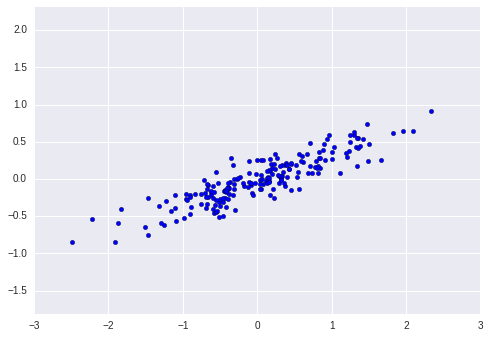

In [21]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [22]:
X.shape

(200, 2)

By eye, it is clear that there is a nearly linear relationship between the x and y variables.
The problem setting here is slightly different: rather than attempting to *predict* the y values from the x values, the unsupervised learning problem attempts to learn about the *relationship* between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [24]:
print pca.explained_variance_

[ 0.75871884  0.01838551]


In [25]:
print pca.components_

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


(-3.0, 3.0, -1.0, 1.5)

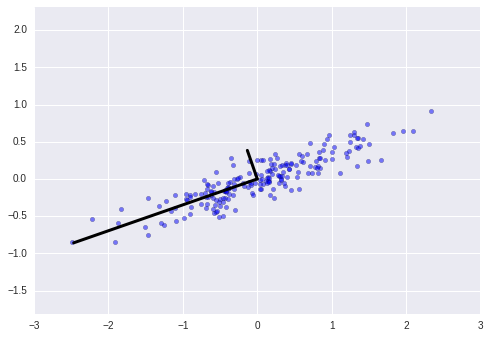

In [26]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]],'-k', lw=3, )

    
plt.axis('equal')

Notice that one vector is longer than the other. In a sense, this tells us that that direction in the data is somehow more "important" than the other direction.
The explained variance quantifies this measure of "importance" in direction.

These vectors represent the *principal axes* of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.


Another way to think of it is that the second principal component could be **completely ignored** without much loss of information! Let's see what our data look like if we only keep 95% of the variance:

In [27]:
clf = PCA(0.95)
X2 = clf.fit_transform(X)
print X.shape
print X2.shape

(200, 2)
(200, 1)


By specifying that we want to throw away 5% of the variance, the data is now compressed by a factor of 50%! Let's see what the data look like after this compression:

In [28]:
Xnew = clf.inverse_transform(X2)

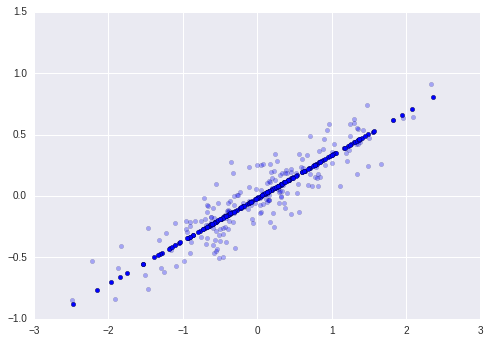

In [29]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

This is the sense in which "dimensionality reduction" works: if you can approximate a data set in a lower dimension, you can often have an easier time visualizing it or fitting complicated models to the data.

### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the digits data

In [30]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [42]:
digits.data[0]

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [31]:
pca = PCA(2)
proj = pca.fit_transform(digits.data)


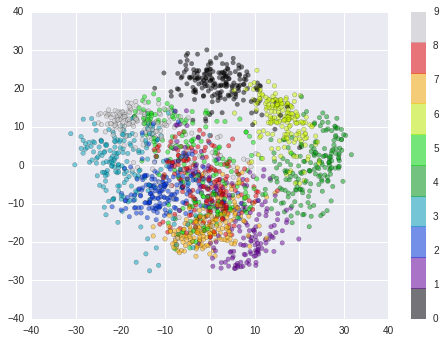

In [32]:
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target, cmap=plt.cm.get_cmap('spectral', 10), alpha=0.5)
plt.colorbar()

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.


### What do the components mean?

We can go a bit further here, and begin to ask what the reduced dimensions *mean*.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!


![](figures/05.09-digits-pixel-components.png)


The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image.
Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image.
Were we to continue this sequence and use all 64 pixels, we would recover the original image.


But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.
This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:


![](figures/05.09-digits-pca-components.png)



Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus eight components!
The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example.
This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.



### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:

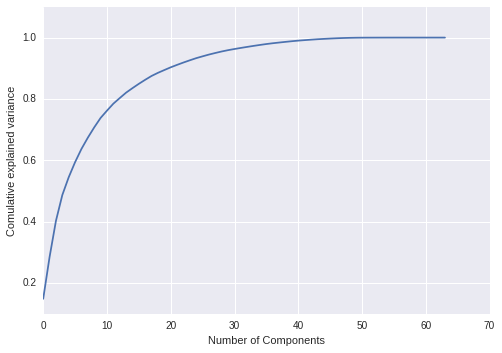

In [33]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Comulative explained variance')
plt.xlabel('Number of Components')

## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free data:

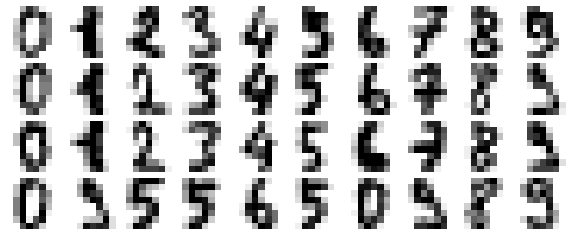

In [34]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

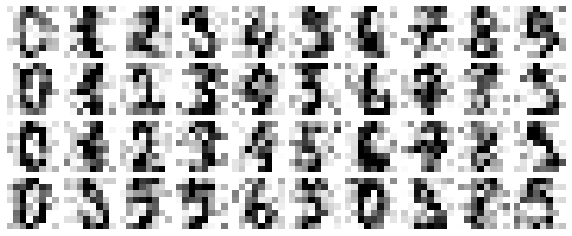

In [35]:
# adding noise to data
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels. Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

In [36]:
pca_noisey = PCA(0.50).fit(noisy)
pca_noisey.n_components_

12

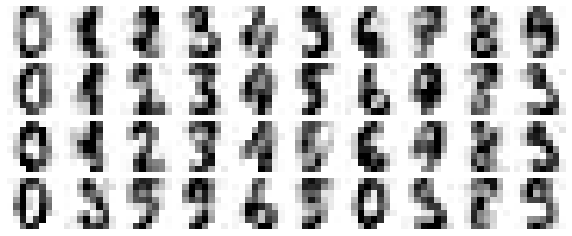

In [37]:
# 50% variance uses 12 components, lets transform data with this estimator:

compo = pca_noisey.transform(noisy)
filtered = pca_noisey.inverse_transform(compo)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

## Example: Eigenfaces

Earlier we explored an example of using a PCA projection as a feature selector for facial recognition with a support vector machine.
Here we will take a look back and explore a bit more of what went into that.
Recall that we were using the Labeled Faces in the Wild dataset made available through Scikit-Learn:

In [38]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print faces.target_names
print faces.images.shape


['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


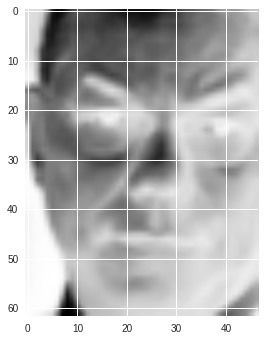

In [39]:

plt.imshow(faces.images[0])

Let's take a look at the principal axes that span this dataset.
Because this is a large dataset, we will use ``RandomizedPCA``—it contains a randomized method to approximate the first $N$ principal components much more quickly than the standard ``PCA`` estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000).
We will take a look at the first 150 components:

In [40]:
rpca = PCA(svd_solver='randomized', n_componentsfrom sklearn.d=150)
rpca.fit(faces.data)

SyntaxError: invalid syntax (<ipython-input-40-253836228ebd>, line 1)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors," so these types of images are often called "eigenfaces"). As you can see in this figure, they are as creepy as they sound:
In [19]:

fig, axes = plt.subplots(3, 8, figsize=(9, 4),

In [ ]:
fig, axes = plt.subplots(3, 8, figsize=(12,5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw={'hspace':0.4, 'wspace':0.4})

for i, ax in enumerate(axes.flat):
    ax.imshow(rpca.components_[i].reshape(62, 47), cmap='gray')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

In [ ]:
plt.plot(np.cumsum(rpca.explained_variance_ratio_))
plt.ylabel('Comulative explained Variance')
plt.xlabel('Number of Components')

We see that these 150 components account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [ ]:
pca = PCA(150, svd_solver='randomized')
comp = pca.fit_transform(faces.data)
proj = pca.inverse_transform(comp)


In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(10, 3),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(10):
    axes[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    axes[1, i].imshow(proj[i].reshape(62, 47), cmap='binary_r')
    
axes[0, 0].set_ylabel('full dim \n input')
axes[1, 0].set_ylabel('150 dim \n input')

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features. This visualization makes clear why the PCA feature selection used in In-Depth: Support Vector Machines was so successful: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image. What this means is that our classification algorithm needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

## Principal Component Analysis Summary


In this section we have discussed the use of principal component analysis for dimensionality reduction, for visualization of high-dimensional data, for noise filtering, and for feature selection within high-dimensional data. Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines.

Given any high-dimensional dataset, we tend to start with PCA in order to visualize the relationship between points (as we did with the digits), to understand the main variance in the data (as we did with the eigenfaces), and to understand the intrinsic dimensionality (by plotting the explained variance ratio). 

Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA's main weakness is that it tends to be highly affected by outliers in the data. For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components. 

Scikit-Learn contains a couple interesting variants on PCA, including RandomizedPCA and SparsePCA, both also in the sklearn.decomposition submodule. 

RandomizedPCA, which we saw earlier, uses a non-deterministic method to quickly approximate the first few principal components in very high-dimensional data, while SparsePCA introduces a regularization term (see In Depth: Linear Regression) that serves to enforce sparsity of the components.


In the following sections, we will look at other unsupervised learning methods that build on some of the ideas of PCA.